<a href="https://colab.research.google.com/github/Harikasaina/ProjetPSD/blob/master/PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## M1
### Enjeux de la personnalisation marketing
SWOT pour la Personnalisation Marketing\
Forces :\
Données Abondantes : Accès à de grandes quantités de données clients pour une personnalisation précise.\
Technologies Avancées : Utilisation de l'IA pour analyser les données et automatiser les processus marketing.\
Personnalisation : Capacité à offrir des expériences client hautement personnalisées, augmentant l'engagement et la fidélité.\
Faiblesses :\
Confidentialité des Données : Risques liés à la collecte et à l'utilisation des données personnelles des clients.\
Dépendance Technologique : Besoin constant de technologies avancées et de compétences spécifiques pour les exploiter.\
Coûts Élevés : Investissements importants nécessaires pour mettre en place et maintenir des stratégies de personnalisation efficaces.\
Opportunités :\
Marchés Ciblés : Capacité à atteindre des segments de marché très spécifiques avec des messages personnalisés.\
Amélioration Continue : Utilisation des données pour continuellement améliorer et adapter les stratégies marketing. Fidélisation Client : Augmentation de la fidélité client grâce à des expériences personnalisées.\
Menaces :\
Réglementations : Évolution des lois sur la protection des données pouvant impacter les stratégies de personnalisation.\
Concurrence : Risque que les concurrents adoptent des stratégies similaires ou plus efficaces.\
Saturation : Risque de saturation des clients avec trop de messages personnalisés, pouvant mener à une lassitude.\

## M2  

In [25]:
import numpy as np
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier, plot_importance

import joblib

### Nettoyage,visualisation,résumé des données clients

✅ Fichier 'cleaned_customers.csv' créé avec succès.

--- Résumé des Données Clients ---

Résumé Statistique Global :
              Age  Total_Spent
count  100.000000   100.000000
mean    43.090000   612.888500
std     13.821441   229.050449
min     18.000000   203.550000
25%     31.750000   443.960000
50%     44.000000   639.415000
75%     55.000000   790.385000
max     65.000000   995.570000

Répartition par Genre :
Gender
Male      52
Female    48
Name: count, dtype: int64

Top 5 des villes par nombre de clients :
Location
Atlanta        14
Seattle        14
Phoenix        11
New York       10
Los Angeles    10
Name: count, dtype: int64

Dépenses Moyennes par Genre :
Gender
Female    639.112500
Male      588.681731
Name: Total_Spent, dtype: float64

--- Visualisations des Données Clients ---


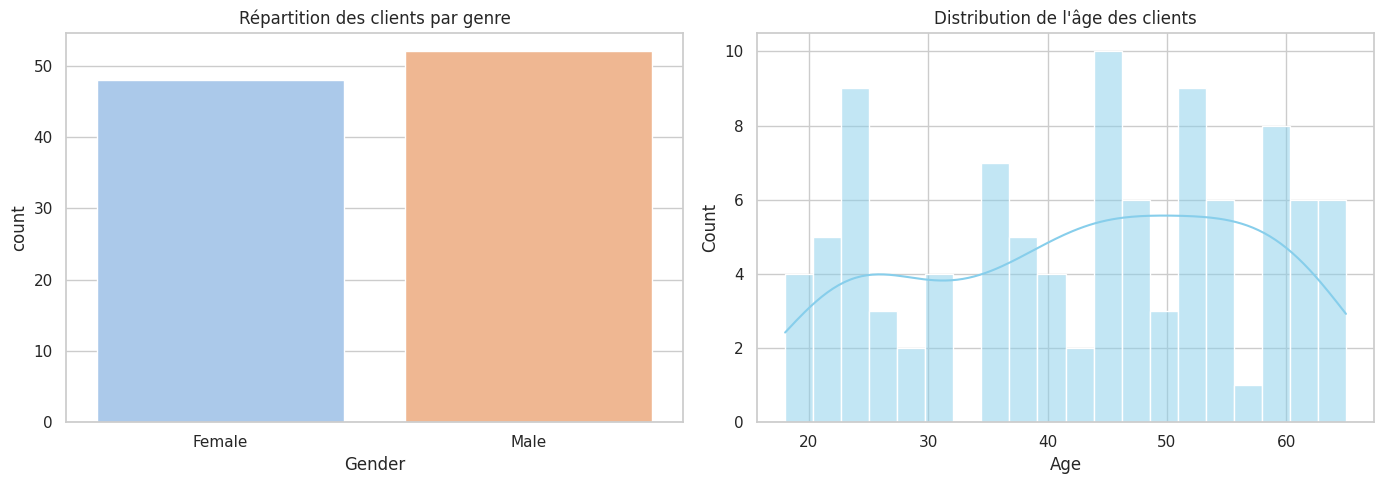

/tmp/ipython-input-2746195614.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations_spent.values, y=top_locations_spent.index, palette="viridis")


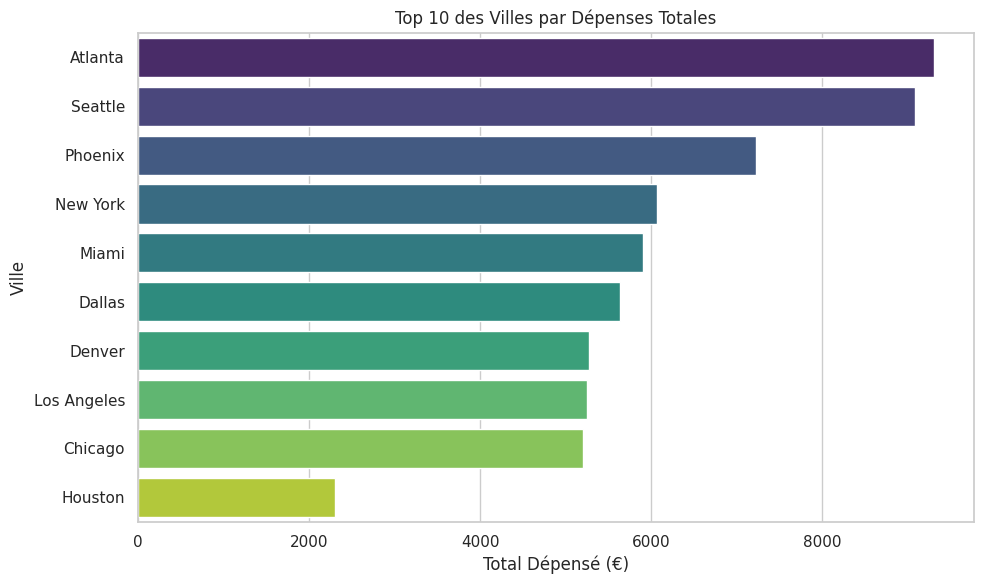

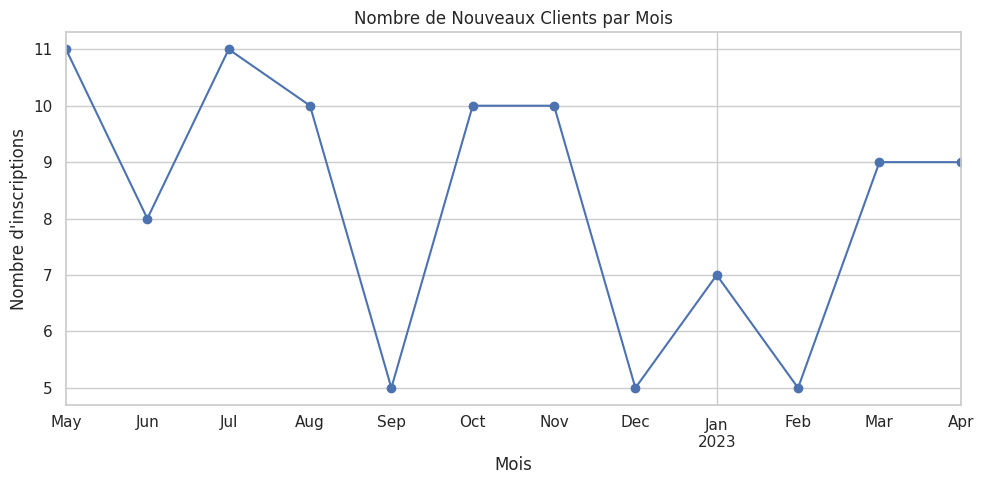

In [26]:
# --- 1. CHARGEMENT ET NETTOYAGE ---
# On charge le fichier une seule fois
df_customers = pd.read_csv("customers_data.csv")

# On applique toutes les étapes de nettoyage en séquence
df_customers.drop_duplicates(inplace=True)
df_customers.dropna(inplace=True)
df_customers['Customer_ID'] = pd.to_numeric(df_customers['Customer_ID'], errors='coerce')
df_customers['Age'] = pd.to_numeric(df_customers['Age'], errors='coerce')
df_customers['Total_Spent'] = pd.to_numeric(df_customers['Total_Spent'], errors='coerce')
df_customers['Join_Date'] = pd.to_datetime(df_customers['Join_Date'], errors='coerce')
df_customers.dropna(inplace=True) # On supprime les lignes où la conversion a échoué

# Filtrage et formatage
df_customers = df_customers[(df_customers['Age'] >= 15) & (df_customers['Age'] <= 100)]
df_customers = df_customers[df_customers['Total_Spent'] >= 0]
df_customers['Name'] = df_customers['Name'].str.strip().str.title()
df_customers['Gender'] = df_customers['Gender'].str.strip().str.capitalize()
df_customers['Location'] = df_customers['Location'].str.strip().str.title()
df_customers.reset_index(drop=True, inplace=True)

# Sauvegarde du fichier nettoyé pour une utilisation future
df_customers.to_csv("cleaned_customers.csv", index=False)
print("✅ Fichier 'cleaned_customers.csv' créé avec succès.")


# --- 2. RÉSUMÉ STATISTIQUE ET INFORMATIONS CLÉS ---
print("\n--- Résumé des Données Clients ---")
print("\nRésumé Statistique Global :")
print(df_customers[['Age', 'Total_Spent']].describe())

print("\nRépartition par Genre :")
print(df_customers['Gender'].value_counts())

print("\nTop 5 des villes par nombre de clients :")
print(df_customers['Location'].value_counts().head(5))

print("\nDépenses Moyennes par Genre :")
print(df_customers.groupby('Gender')['Total_Spent'].mean())


# --- 3. VISUALISATIONS ---
print("\n--- Visualisations des Données Clients ---")
sns.set(style="whitegrid")

# Graphique 1 & 2 : Genre et Âge
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_customers, x="Gender", hue="Gender", palette="pastel", legend=False)
plt.title("Répartition des clients par genre")

plt.subplot(1, 2, 2)
sns.histplot(df_customers['Age'], bins=20, kde=True, color='skyblue')
plt.title("Distribution de l'âge des clients")
plt.tight_layout()
plt.show()

# Graphique 3 : Dépenses totales par ville (top 10)
plt.figure(figsize=(10, 6))
top_locations_spent = df_customers.groupby("Location")["Total_Spent"].sum().nlargest(10)
sns.barplot(x=top_locations_spent.values, y=top_locations_spent.index, palette="viridis")
plt.title("Top 10 des Villes par Dépenses Totales")
plt.xlabel("Total Dépensé (€)")
plt.ylabel("Ville")
plt.tight_layout()
plt.show()

# Graphique 4 : Évolution des inscriptions dans le temps
plt.figure(figsize=(10, 5))
monthly_join = df_customers.resample('ME', on='Join_Date')['Customer_ID'].count()
monthly_join.plot(marker='o', linestyle='-')
plt.title("Nombre de Nouveaux Clients par Mois")
plt.xlabel("Mois")
plt.ylabel("Nombre d'inscriptions")
plt.grid(True)
plt.tight_layout()
plt.show()

### Nettoyage,visualisation et resumé de ventes

--- Résumé des Données de Ventes ---

 Aperçu des données nettoyées :
   Sale_ID  Product_ID  Customer_ID       Date  Quantity  Sale_Price  \
0        1         133         2010 2023-04-07         1       70.28   
1        2         161         2069 2023-01-06         1      265.92   
2        3         106         2007 2023-02-23         3       87.54   
3        4         173         2036 2023-02-17         3       37.41   
4        5         118         2007 2023-03-05         5      127.16   

    Channel  Total_Sale  
0  In-Store       70.28  
1    Online      265.92  
2  In-Store      262.62  
3    Online      112.23  
4    Online      635.80  

 Résumé statistique :
        Quantity  Sale_Price   Total_Sale
count  100.00000  100.000000   100.000000
mean     2.99000  156.902300   463.622100
std      1.47364   82.055663   357.892098
min      1.00000   11.680000    33.320000
25%      2.00000   91.627500   193.337500
50%      3.00000  153.140000   358.925000
75%      4.00000  225.41

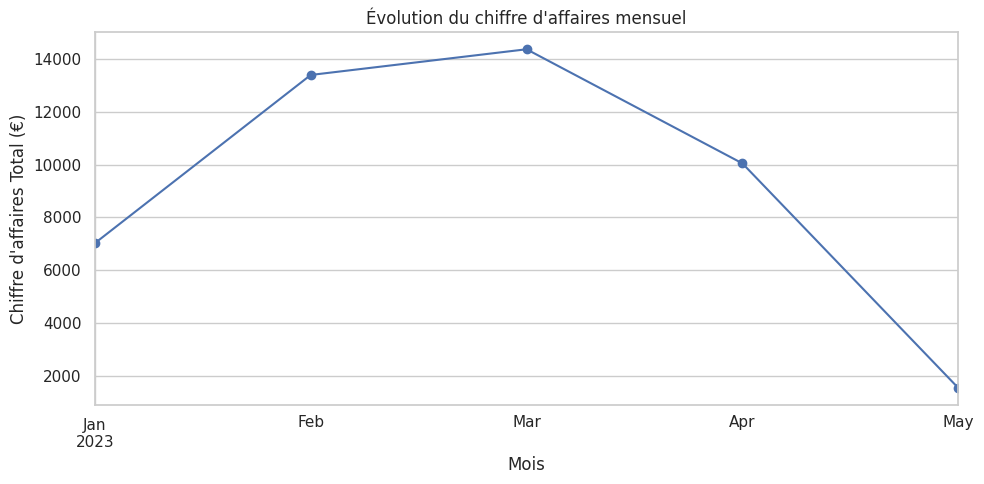

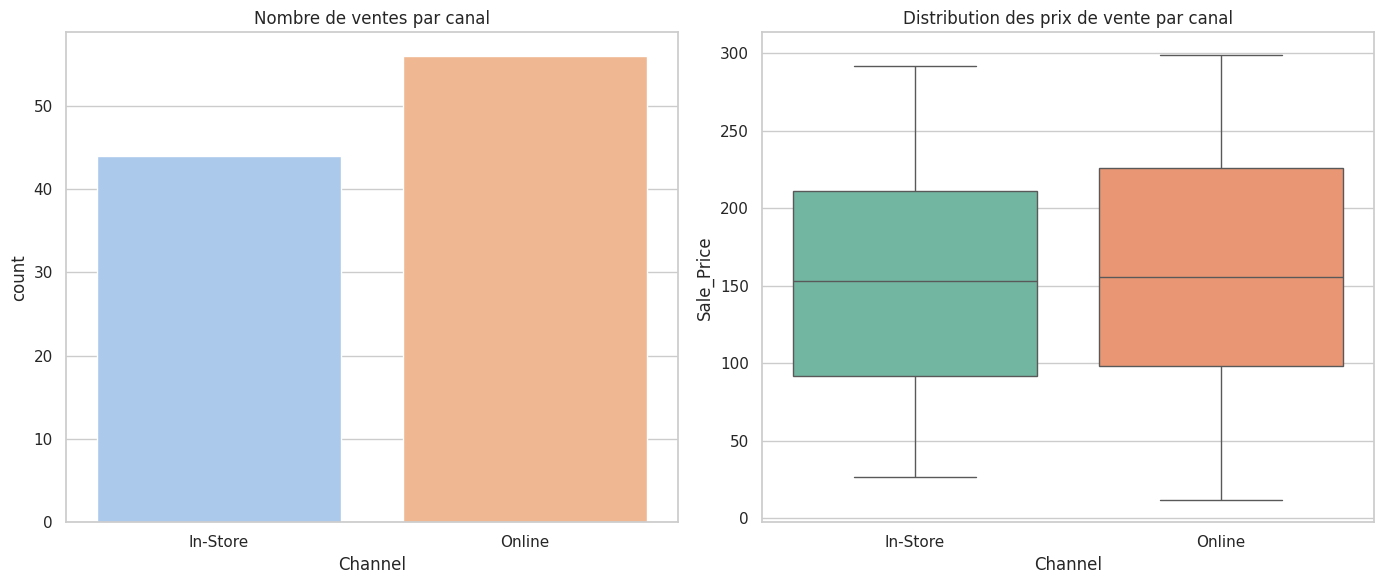

In [27]:
# --- 1. CHARGEMENT ET NETTOYAGE COMPLET ---
# On charge le fichier une seule fois
df_sales = pd.read_csv("sales_data.csv")

# On supprime les espaces dans les noms de colonnes
df_sales.columns = df_sales.columns.str.strip()

# On supprime les doublons et les lignes avec des valeurs manquantes critiques
df_sales.drop_duplicates(inplace=True)
df_sales.dropna(subset=['Customer_ID', 'Product_ID', 'Date'], inplace=True)

# Conversion des types de données (gère les erreurs en créant des NaN)
df_sales['Date'] = pd.to_datetime(df_sales['Date'], errors='coerce')
df_sales['Quantity'] = pd.to_numeric(df_sales['Quantity'], errors='coerce')
df_sales['Sale_Price'] = pd.to_numeric(df_sales['Sale_Price'], errors='coerce')

# On supprime les lignes où la conversion a échoué
df_sales.dropna(inplace=True)

# Création de la colonne de revenu total par vente
df_sales['Total_Sale'] = df_sales['Quantity'] * df_sales['Sale_Price']


# --- 2. RÉSUMÉ STATISTIQUE ET INFORMATIONS CLÉS ---
print("--- Résumé des Données de Ventes ---")
print("\n Aperçu des données nettoyées :")
print(df_sales.head())

print("\n Résumé statistique :")
print(df_sales[['Quantity', 'Sale_Price', 'Total_Sale']].describe())

print("\n Informations générales :")
print(f" Nombre de ventes : {len(df_sales)}")
print(f" Nombre de clients uniques : {df_sales['Customer_ID'].nunique()}")
print(f" Nombre de produits uniques : {df_sales['Product_ID'].nunique()}")
print(f" Période de vente : {df_sales['Date'].min().strftime('%Y-%m-%d')} à {df_sales['Date'].max().strftime('%Y-%m-%d')}")

print("\n Nombre de ventes par canal :")
print(df_sales['Channel'].value_counts())

print("\n Top 5 produits les plus vendus :")
print(df_sales['Product_ID'].value_counts().head(5))

print("\n Chiffre d'affaires total par canal :")
print(df_sales.groupby("Channel")["Total_Sale"].sum())


# --- 3. VISUALISATIONS ---
print("\n--- Visualisations des Données de Ventes ---")
sns.set(style="whitegrid")

# Graphique 1 : Ventes totales par mois
plt.figure(figsize=(10, 5))
monthly_sales = df_sales.resample('ME', on='Date')['Total_Sale'].sum()
monthly_sales.plot(marker='o')
plt.title("Évolution du chiffre d'affaires mensuel")
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaires Total (€)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Graphique 2 et 3 : Analyse par canal
plt.figure(figsize=(14, 6))

# Sous-graphique 1 : Nombre de ventes par canal
plt.subplot(1, 2, 1)
sns.countplot(data=df_sales, x="Channel", hue="Channel", palette="pastel", legend=False)
plt.title("Nombre de ventes par canal")

# Sous-graphique 2 : Distribution des prix par canal
plt.subplot(1, 2, 2)
sns.boxplot(data=df_sales, x="Channel", y="Sale_Price", hue="Channel", palette="Set2", legend=False)
plt.title("Distribution des prix de vente par canal")

plt.tight_layout()
plt.show()

### Nettoyages,visualisations et résumé des donnés produits

Résumé descriptif des prix :
count    100.000000
mean     161.961200
std       76.570448
min       10.340000
25%      112.130000
50%      162.900000
75%      221.705000
max      293.250000
Name: Price, dtype: float64

Nombre de produits par catégorie :
Category
Clothing       48
Accessories    23
Footwear       19
Outerwear      10
Name: count, dtype: int64

Nombre de produits par marque :
Brand
Brand D    19
Brand G    18
Brand B    17
Brand A    16
Brand E    13
Brand F    11
Brand C     6
Name: count, dtype: int64


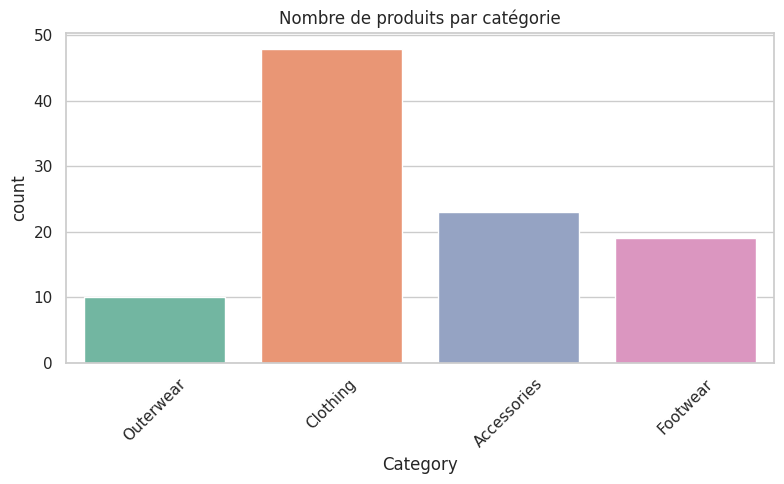

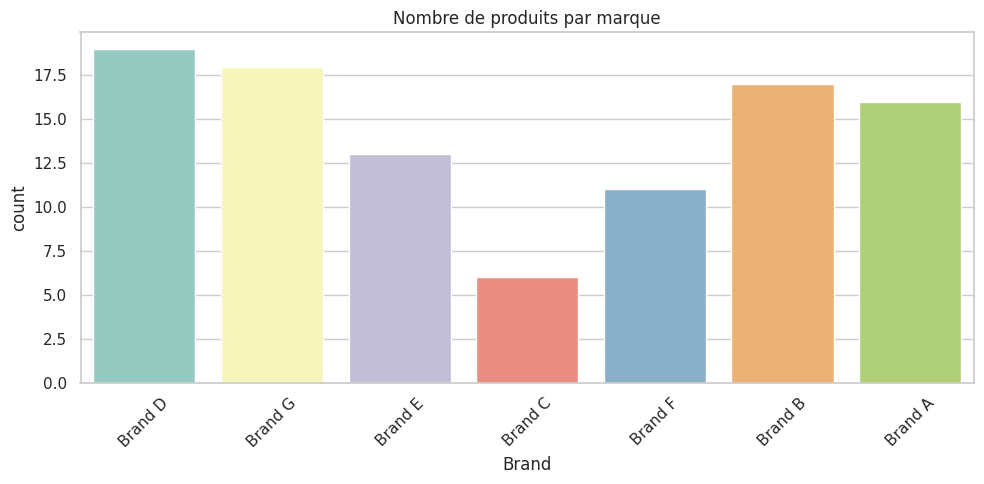

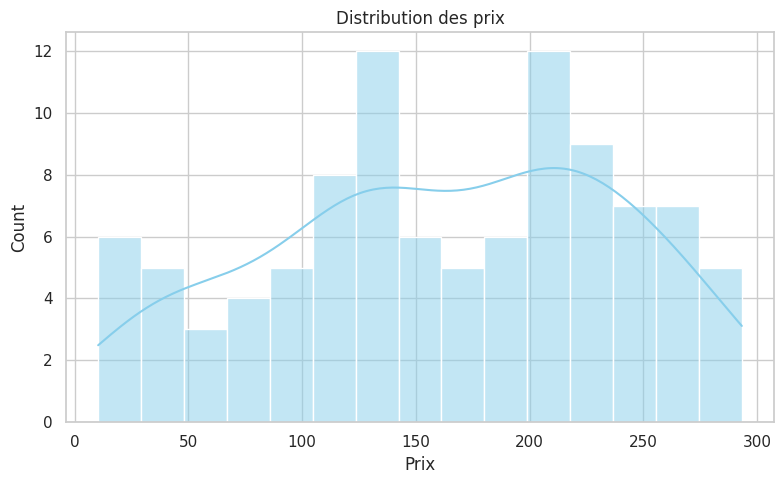

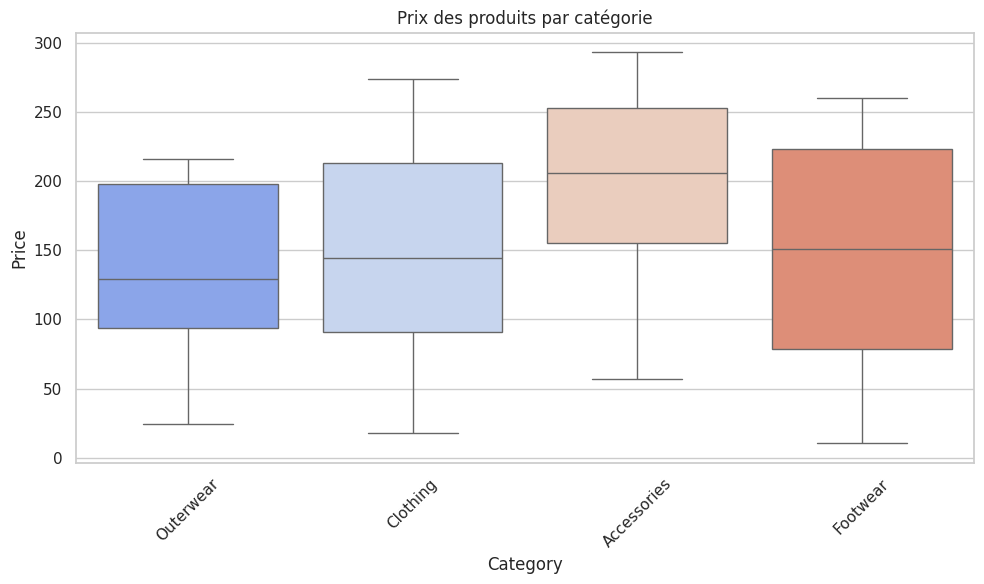

In [28]:
df = pd.read_csv("products_data.csv")

# 2. Nettoyage de base
df.columns = df.columns.str.strip()  # Supprime les espaces
df.drop_duplicates(inplace=True)    # Supprime les doublons
df.dropna(inplace=True)             # Supprime les lignes vides

# Vérification des types de données
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df.dropna(subset=['Price'], inplace=True)

# 3. Résumé statistique
print("Résumé descriptif des prix :")
print(df['Price'].describe())

print("\nNombre de produits par catégorie :")
print(df['Category'].value_counts())

print("\nNombre de produits par marque :")
print(df['Brand'].value_counts())

# 4. Visualisations
sns.set(style="whitegrid")

# a. Répartition des produits par catégorie
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Category', hue='Category', palette='Set2', legend=False)

plt.title("Nombre de produits par catégorie")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# b. Répartition des produits par marque
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Brand', hue='Brand', palette='Set3', legend=False)

plt.title("Nombre de produits par marque")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# c. Distribution des prix
plt.figure(figsize=(8, 5))
sns.histplot(df['Price'], bins=15, kde=True, color='skyblue')
plt.title("Distribution des prix")
plt.xlabel("Prix")
plt.tight_layout()
plt.show()

# d. Boxplot des prix par catégorie
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Category', hue='Category', y='Price', palette='coolwarm')
plt.title("Prix des produits par catégorie")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## M3 Créations des clusters basés sur l'âge,depenses et produits achetés

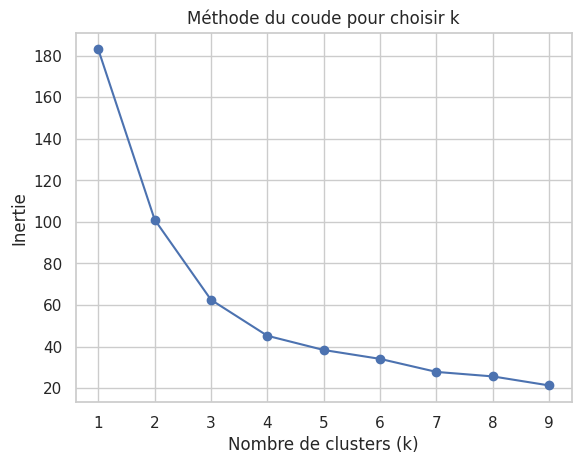

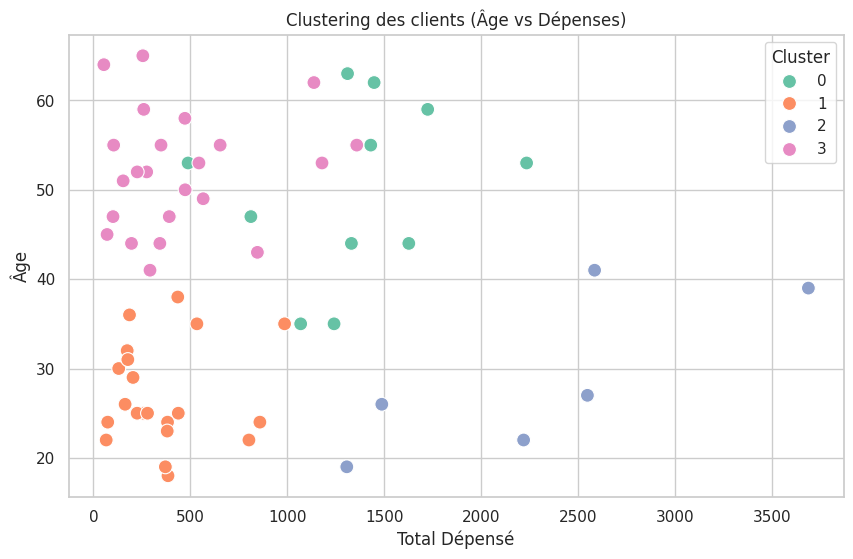

nCluster2
             Age  Total_Spent  Products_Bought
count   6.000000     6.000000         6.000000
mean   29.000000  2306.350000         3.500000
std     9.011104   863.039778         0.547723
min    19.000000  1307.200000         3.000000
25%    23.000000  1670.797500         3.000000
50%    26.500000  2384.150000         3.500000
75%    36.000000  2576.500000         4.000000
max    41.000000  3688.970000         4.000000
nCluster0
             Age  Total_Spent  Products_Bought
count  11.000000    11.000000        11.000000
mean   50.000000  1338.067273         2.545455
std     9.838699   462.494669         0.522233
min    35.000000   488.260000         2.000000
25%    44.000000  1155.315000         2.000000
50%    53.000000  1331.010000         3.000000
75%    57.000000  1537.640000         3.000000
max    63.000000  2234.920000         3.000000
nCluster1
             Age  Total_Spent  Products_Bought
count  21.000000    21.000000        21.000000
mean   27.047619   357.525238 

In [29]:
# chargement de deux fichiers
sales_df = pd.read_csv("sales_data.csv")  # Fichier des ventes
customers_df = pd.read_csv("customers_data.csv")  # Fichier clients

# --- Nettoyage des données  ---
sales_df['Sale_Price'] = pd.to_numeric(sales_df['Sale_Price'], errors='coerce')
sales_df['Quantity'] = pd.to_numeric(sales_df['Quantity'], errors='coerce')
sales_df['Total_Sale'] = sales_df['Quantity'] * sales_df['Sale_Price']
sales_df.dropna(subset=["Customer_ID", "Total_Sale"], inplace=True)

# Fusion des données clients + ventes
df = pd.merge(customers_df, sales_df, on="Customer_ID")

# --- Agrégation par client ---
client_features = df.groupby("Customer_ID").agg({
    "Age": "first",  # âge du client
    "Total_Sale": "sum",  # dépenses totales
    "Product_ID": "nunique"  # nombre de produits différents achetés
}).rename(columns={
    "Total_Sale": "Total_Spent",
    "Product_ID": "Products_Bought"
}).reset_index()

# --- Standardisation des variables ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(client_features[["Age", "Total_Spent", "Products_Bought"]])

# --- Détermination du nombre optimal de clusters (optionnel) ---
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.title("Méthode du coude pour choisir k")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.show()

# --- K-Means clustering final ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
client_features['Cluster'] = kmeans.fit_predict(X_scaled)

# --- Visualisation des clusters ---
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=client_features,
                x="Total_Spent", y="Age",
                hue="Cluster", palette="Set2", s=100)
plt.title("Clustering des clients (Âge vs Dépenses)")
plt.xlabel("Total Dépensé")
plt.ylabel("Âge")
plt.legend(title="Cluster")
plt.show()


for i in client_features['Cluster'].unique():
    print(f"nCluster{i}")
    print( client_features[client_features['Cluster']==i][['Age','Total_Spent','Products_Bought']].describe())


## M4 Identification des caractéristiques et préférences de chaque segment

In [30]:
# Statistiques générales par cluster
cluster_summary = client_features.groupby("Cluster").agg({
    "Age": ["mean", "min", "max"],
    "Total_Spent": ["mean", "sum"],
    "Products_Bought": ["mean", "max", "min"],
    "Customer_ID": "count"
}).rename(columns={"Customer_ID": "Nb_Clients"})

print(" Résumé des clusters :")
print(cluster_summary)


 Résumé des clusters :
               Age          Total_Spent           Products_Bought          \
              mean min max         mean       sum            mean max min   
Cluster                                                                     
0        50.000000  35  63  1338.067273  14718.74        2.545455   3   2   
1        27.047619  18  38   357.525238   7508.03        1.095238   2   1   
2        29.000000  19  41  2306.350000  13838.10        3.500000   4   3   
3        52.130435  41  65   447.710435  10297.34        1.173913   2   1   

        Nb_Clients  
             count  
Cluster             
0               11  
1               21  
2                6  
3               23  


Cluster 0 – Seniors dépensiers
Âge moyen : 50 ans
Total dépensé moyen : 1338 €
Nombre de produits achetés : 2 à 3 (moyenne : 2.55)
Nombre de clients : 11

Profil :
Ce sont des clients plus âgés, qui dépensent relativement beaucoup.
Ils achètent peu de produits, mais leur panier moyen est élevé.
Préférence : Qualité > quantité – ils sont sans doute sensibles à des produits premium ou bien ciblés.

 Cluster 1 – Jeunes à faible pouvoir d’achat
Âge moyen : 27 ans
Total dépensé moyen : 357 €
Produits achetés : 1 produit en général
Nombre de clients : 21

Profil :
Jeunes adultes avec un budget limité.
Très peu d’achats, faible valeur client.
Préférence : Offres promotionnelles, premiers prix, contenu dynamique et engageant

 Cluster 2 – Jeunes très rentables
Âge moyen : 29 ans
Total dépensé moyen : 2306 € (le plus élevé)
Produits achetés : 3 à 4 (moyenne : 3.5)
Nombre de clients : 6

Profil :
Petits en nombre, mais très importants en valeur.
Ils sont jeunes et achètent beaucoup.
Préférence : Produits tendance, nouveautés, cross-selling pertinent.

 Cluster 3 – Seniors modérés
Âge moyen : 52 ans
Total dépensé moyen : 447 €
Produits achetés : 1 à 2
Nombre de clients : 23
Profil :

Population plus âgée, mais au pouvoir d’achat modéré.
Achètent peu, mais sont nombreux.
Préférence : Fiabilité, service client, produits classiques.

 Recommandations marketing
Cluster 0 : Campagnes premium, exclusivité, service VIP.
Cluster 1 : Réductions, contenu sur TikTok / Instagram, offres de bienvenue.
Cluster 2 : Fidélisation forte, bundles, recommandations personnalisées.
Cluster 3 : Newsletters informatives, assurance qualité, confiance dans la marque.



## M5 Analyse des performance des campagnes marketing

In [31]:
try:
    # 1. Charger le fichier brut des campagnes
    df = pd.read_csv("marketing_data.csv")

    # 2. Calculer les indicateurs de performance (KPIs) de manière sécurisée

    # On vérifie que les Impressions > 0 avant de diviser
    df["CTR (%)"] = np.where(df["Impressions"] > 0, (df["Clicks"] / df["Impressions"]) * 100, 0)

    # On vérifie que les Clics > 0 avant de diviser
    df["CPC (€)"] = np.where(df["Clicks"] > 0, df["Budget"] / df["Clicks"], 0)

    # Simuler les conversions si elles n'existent pas
    if "Conversions" not in df.columns:
        df["Conversions"] = (df["Clicks"] * 0.03).astype(int)

    # On vérifie que les Clics > 0 avant de diviser
    df["Conversion_Rate (%)"] = np.where(df["Clicks"] > 0, (df["Conversions"] / df["Clicks"]) * 100, 0)

    # On vérifie que les Conversions > 0 avant de diviser
    df["CPA (€)"] = np.where(df["Conversions"] > 0, df["Budget"] / df["Conversions"], 0)

    # Revenu et Retour sur Investissement
    revenue_per_conversion = 100
    df["Revenue"] = df["Conversions"] * revenue_per_conversion

    # On vérifie que le Budget > 0 avant de diviser
    df["ROI (%)"] = np.where(df["Budget"] > 0, ((df["Revenue"] - df["Budget"]) / df["Budget"]) * 100, 0)

    # 3. Sauvegarder le nouveau fichier propre en une seule fois
    df.to_csv("campaign_performance.csv", index=False)

    print("✅ Le fichier 'campaign_performance.csv' a été créé avec succès !")
    print("Aperçu du fichier généré :")
    print(df.head())

except FileNotFoundError:
    print("❌ Erreur : Le fichier source 'marketing_data.csv' est introuvable.")
except Exception as e:
    print(f"❌ Une erreur est survenue : {e}")

✅ Le fichier 'campaign_performance.csv' a été créé avec succès !
Aperçu du fichier généré :
   Campaign_ID Channel  Start_Date    End_Date   Budget  Impressions  Clicks  \
0            1   Email  2023-02-24  2023-03-23  4509.70        96713    2885   
1            2   Email  2023-01-14  2023-01-21  4473.50        71432    4310   
2            3   Email  2023-02-18  2023-03-18   821.52        57724    3805   
3            4  Social  2023-03-02  2023-03-24  3254.82        59843     935   
4            5      TV  2023-01-02  2023-01-15  1085.03        10743    3347   

   Conversions    CTR (%)   CPC (€)  Conversion_Rate (%)    CPA (€)  Revenue  \
0          189   2.983053  1.563154             6.551127  23.860847    18900   
1          165   6.033710  1.037935             3.828306  27.112121    16500   
2         1482   6.591712  0.215905            38.948752   0.554332   148200   
3          337   1.562422  3.481091            36.042781   9.658220    33700   
4         1365  31.155171  

## M6 Prédiction de churn

In [32]:
# --- 1. Chargement et préparation des données ---
try:
    customers = pd.read_csv("cleaned_customers.csv")
    sales = pd.read_csv("sales_data.csv")

    # Création des features
    customer_features = sales.groupby("Customer_ID").agg(
        Total_Spent_Calc=("Sale_Price", "sum"),
        Total_Orders=("Sale_ID", "count"),
        Last_Purchase=("Date", "max")
    ).reset_index()

    customer_features["Last_Purchase"] = pd.to_datetime(customer_features["Last_Purchase"])
    reference_date = pd.to_datetime("2023-07-01")
    customer_features["Recency"] = (reference_date - customer_features["Last_Purchase"]).dt.days

    df = pd.merge(customers, customer_features, on="Customer_ID")
    df["Is_Loyal"] = (df["Total_Orders"] > 2).astype(int)

    # --- 2. Encodage et sélection des features ---
    df_encoded = pd.get_dummies(df, columns=["Gender", "Location"], drop_first=True)

    features_to_use = [col for col in df_encoded.columns if col not in [
        "Customer_ID", "Name", "Join_Date", "Last_Purchase", "Is_Loyal", "Total_Spent"
    ]]

    X = df_encoded[features_to_use]
    y = df_encoded["Is_Loyal"]

    # --- 3. Entraînement du modèle final ---
    final_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
    final_model.fit(X, y)

    # --- 4. Sauvegarde du modèle et des colonnes ---
    joblib.dump(final_model, 'loyalty_model.joblib')
    joblib.dump(X.columns.tolist(), 'model_columns.pkl')

    print("✅ Modèle 'loyalty_model.joblib' et colonnes 'model_columns.pkl' sauvegardés avec succès !")
    print("Vous pouvez maintenant les téléverser dans votre session Colab pour le dashboard.")

except FileNotFoundError:
    print("❌ Erreur : Assurez-vous que 'cleaned_customers.csv' et 'sales_data.csv' sont présents.")

✅ Modèle 'loyalty_model.joblib' et colonnes 'model_columns.pkl' sauvegardés avec succès !
Vous pouvez maintenant les téléverser dans votre session Colab pour le dashboard.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy du modèle (fidélité client) : 1.0


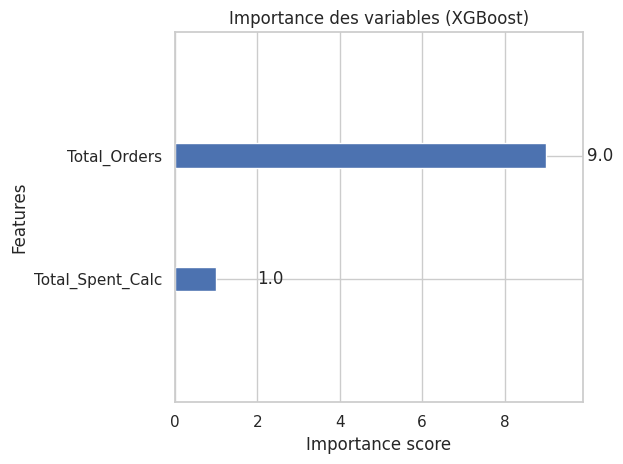

In [33]:
# 1. Charger les données
customers = pd.read_csv("cleaned_customers.csv")
sales = pd.read_csv("sales_data.csv")

# 2. Préparer les features clients à partir des ventes
customer_features = sales.groupby("Customer_ID").agg({
    "Sale_Price": "sum",
    "Sale_ID": "count",
    "Quantity": "sum",
    "Date": "max"
}).rename(columns={
    "Sale_Price": "Total_Spent_Calc",
    "Sale_ID": "Total_Orders",
    "Quantity": "Total_Quantity",
    "Date": "Last_Purchase"
}).reset_index()

# 3. Calculer la récence
customer_features["Last_Purchase"] = pd.to_datetime(customer_features["Last_Purchase"])
reference_date = pd.to_datetime("2023-07-01")
customer_features["Recency"] = (reference_date - customer_features["Last_Purchase"]).dt.days

# 4. Fusion avec les données clients nettoyées
df = pd.merge(customers, customer_features, on="Customer_ID")

# 5. Créer la variable cible (client fidèle : >2 commandes)
df["Is_Loyal"] = df["Total_Orders"].apply(lambda x: 1 if x > 2 else 0)

# 6. Encodage des variables catégorielles
df = pd.get_dummies(df, columns=["Gender", "Location"], drop_first=True)

# 7. Préparation des features et de la cible
X = df.drop(columns=["Customer_ID", "Name", "Join_Date", "Last_Purchase", "Is_Loyal", "Total_Spent"])
y = df["Is_Loyal"]

# 8. Division des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 9. Entraînement du modèle XGBoost
model = XGBClassifier(eval_metric='logloss')

model.fit(X_train, y_train)

# 10. Prédiction et évaluation
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print("Accuracy du modèle (fidélité client) :", round(accuracy, 4))

# 11. Importance des variables
plot_importance(model)
plt.title("Importance des variables (XGBoost)")
plt.tight_layout()
plt.show()


###  exemple d'une  prédiction

In [34]:
columns_model = ['Age', 'Total_Spent_Calc', 'Total_Orders', 'Total_Quantity', 'Recency',
                 'Gender_Male', 'Location_Chicago', 'Location_Dallas', 'Location_Denver',
                 'Location_Houston', 'Location_Los Angeles', 'Location_Miami',
                 'Location_New York', 'Location_Phoenix', 'Location_Seattle']

input_data = {col: 0 for col in columns_model}
input_data.update({
    'Age': 30,
    'Total_Spent_Calc': 1200.50,
    'Total_Orders': 3,
    'Total_Quantity': 10,
    'Recency': 20,
    'Gender_Male': 1,
    'Location_New York': 1  # Choisir une seule localisation possible
})
sample_df = pd.DataFrame([input_data])
pred_class = model.predict(sample_df)[0]
pred_proba = model.predict_proba(sample_df)[0][1]

print("Classe prédite :", pred_class)
print("Probabilité d'être fidèle :", round(pred_proba * 100, 2), "%")

Classe prédite : 1
Probabilité d'être fidèle : 89.11 %


# M7 Elaboration d'une stratégie Marketing digitale

#### Ciblage personnalisé

| Segment             | Canal recommandé    | Type de contenu                      | Budget suggéré (€) | Objectif     |
| ------------------- | ------------------- | ------------------------------------ | ------------------ | ------------ |
| Fidèles             | Email + App         | Programme VIP, réductions exclusives | 30–40 €/client     | Fidélisation |
| Nouveaux clients    | Social Media        | Tutoriels, témoignages, -10% off     | 15–20 €/client     | Conversion   |
| Clients à réactiver | SMS + Email         | “On vous a manqué” + -15%            | 20–25 €/client     | Réactivation |
| Inactifs            | TV/Display/Retarget | Branding + Offre flash               | 10 €/client        | Notoriété    |


# M8-M9 Dashboard et Rapport final

Créations de fichier pour créer le dashboard


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

try:
    # 1. Charger les données de base
    customers_df = pd.read_csv("cleaned_customers.csv")
    sales_df = pd.read_csv("sales_data.csv")

    # --- MODIFICATION CLÉ ---
    # On supprime l'ancienne colonne 'Total_Spent' pour éviter les conflits
    if 'Total_Spent' in customers_df.columns:
        customers_df = customers_df.drop('Total_Spent', axis=1)

    # 2. Agréger les données de vente pour recalculer les features
    aggregated_features = sales_df.groupby("Customer_ID").agg(
        Total_Spent=("Sale_Price", "sum"),
        Products_Bought=("Product_ID", "nunique")
    ).reset_index()

    # 3. Fusionner les données clients (sans 'Total_Spent') avec les nouvelles features
    client_features_complete = pd.merge(customers_df, aggregated_features, on="Customer_ID", how="left")
    client_features_complete.fillna(0, inplace=True)

    # 4. Standardisation et Clustering
    features_for_scaling = client_features_complete[["Age", "Total_Spent", "Products_Bought"]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_for_scaling)

    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    client_features_complete['Cluster'] = kmeans.fit_predict(X_scaled)

    # 5. Sauvegarder le fichier final et propre
    client_features_complete.to_csv("clustered_clients01.csv", index=False)

    print("✅ Le fichier 'clustered_clients01.csv' a été recréé avec succès !")
    print("Aperçu des colonnes :", client_features_complete.columns.tolist())

except FileNotFoundError:
    print("❌ Erreur : Assurez-vous que 'cleaned_customers.csv' et 'sales_data.csv' sont bien téléversés.")
except Exception as e:
    print(f"❌ Une erreur est survenue : {e}")

✅ Le fichier 'clustered_clients01.csv' a été recréé avec succès !
Aperçu des colonnes : ['Customer_ID', 'Name', 'Age', 'Gender', 'Location', 'Join_Date', 'Total_Spent', 'Products_Bought', 'Cluster']


In [36]:
# Charger les fichiers CSV
customers = pd.read_csv("cleaned_customers.csv")
sales = pd.read_csv("sales_data.csv")
campaigns = pd.read_csv("marketing_data.csv")

# Fusion clients + ventes (sur Customer_ID)
merged_df = pd.merge(sales, customers, on="Customer_ID", how="left")

# Fusion avec campagnes (si campagne liée à une vente)
if "Campaign_ID" in merged_df.columns and "Campaign_ID" in campaigns.columns:
    merged_df = pd.merge(merged_df, campaigns, on="Campaign_ID", how="left")

# Enregistrer le fichier fusionné
merged_df.to_csv("merged_data.csv", index=False)

print(" Fichier fusionné enregistré sous 'merged_data.csv'")


 Fichier fusionné enregistré sous 'merged_data.csv'


In [37]:
import pandas as pd

# 1. Charger les données
df = pd.read_csv("merged_data.csv")

# 2. Conversion des dates
df["Date"] = pd.to_datetime(df["Date"])
df["Join_Date"] = pd.to_datetime(df["Join_Date"])

# 3. Agrégation des ventes par client
customer_features = df.groupby("Customer_ID").agg({
    "Sale_Price": "sum",
    "Sale_ID": "count",
    "Quantity": "sum",
    "Date": "max",
    "Age": "first",
    "Gender": "first",
    "Location": "first",
    "Join_Date": "first",
    "Total_Spent": "first",  # déjà présent, sinon recalculable
    "Name": "first"
}).rename(columns={
    "Sale_Price": "Total_Spent_Calc",
    "Sale_ID": "Total_Orders",
    "Quantity": "Total_Quantity",
    "Date": "Last_Purchase"
}).reset_index()

# 4. Calcul de la récence
reference_date = pd.to_datetime("2023-07-01")
customer_features["Recency"] = (reference_date - customer_features["Last_Purchase"]).dt.days

# 5. Variable cible : client fidèle (>2 commandes)
customer_features["Is_Loyal"] = customer_features["Total_Orders"].apply(lambda x: 1 if x > 2 else 0)

# 6. Encodage des variables catégorielles
customer_features_encoded = pd.get_dummies(customer_features, columns=["Gender", "Location"], drop_first=True)

# 7. Enregistrement du fichier enrichi
customer_features_encoded.to_csv("enriched_customers.csv", index=False)
df=pd.read_csv('enriched_customers.csv')
df.head(4)

,Customer_ID,Total_Spent_Calc,Total_Orders,Total_Quantity,Last_Purchase,Age,Join_Date,Total_Spent,Name,Recency,...,Gender_Male,Location_Chicago,Location_Dallas,Location_Denver,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,Location_Phoenix,Location_Seattle
0,2001,481.85,3,7,2023-04-05,26,2023-01-27,658.74,Laura,87,...,False,False,False,False,False,False,False,False,False,False
1,2004,372.70,3,11,2023-04-11,55,2022-08-18,693.76,Olivia,81,...,False,False,False,False,False,False,False,False,False,True
2,2005,73.60,1,1,2023-04-14,24,2022-12-02,447.59,Sophie,78,...,False,False,False,False,False,False,False,False,False,False
3,2006,20.18,1,5,2023-03-03,47,2022-08-07,804.71,Lucas,120,...,True,False,True,False,False,False,False,False,False,False


In [38]:
# Colab cell 1
!pip install -q streamlit pyngrok pandas plotly kaleido reportlab scikit-learn xgboost
# pyngrok permet d'obtenir une URL publique (option)

In [41]:
%%writefile app.py
import streamlit as st
import pandas as pd
import plotly.express as px
import joblib
import warnings

# --- Configuration de la page ---
st.set_page_config(page_title="Dashboard Marketing PSD 2.0", layout="wide")
st.title("📊 Dashboard d'Analyse Marketing et Segmentation Client")

# --- MODIFICATION : Ignorer les avertissements inutiles de XGBoost ---
warnings.filterwarnings("ignore", category=UserWarning)

# --- Chargement des données et du modèle ---
@st.cache_data
def load_data():
    try:
        clients = pd.read_csv("clustered_clients01.csv")
        campaigns = pd.read_csv("campaign_performance.csv", engine='python')
        return clients, campaigns
    except FileNotFoundError:
        st.error("Erreur : Assurez-vous que les fichiers 'clustered_clients01.csv' et 'campaign_performance.csv' sont bien téléversés.")
        return None, None

@st.cache_resource
def load_model():
    try:
        model = joblib.load('loyalty_model.joblib')
        columns = joblib.load('model_columns.pkl')
        return model, columns
    except FileNotFoundError:
        return None, None

clients_df, campaigns_df = load_data()
model, model_columns = load_model()

if clients_df is None or campaigns_df is None:
    st.error("Erreur : Fichiers de données introuvables. Veuillez les téléverser.")
    st.stop()

# --- Interface utilisateur ---
st.sidebar.header("Navigation")
page_options = ["📈 Vue d'ensemble", "🧑‍🤝‍🧑 Analyse des Segments", "📢 Performance des Campagnes"]
if model is not None:
    page_options.append("🔮 Prédiction de Fidélité")

page = st.sidebar.radio("Choisissez une page :", page_options)

# ... Les 3 premières pages
if page == "📈 Vue d'ensemble":
    st.header("Vue d'ensemble des Indicateurs Clés")
    total_clients = clients_df['Customer_ID'].nunique()
    total_revenue = clients_df['Total_Spent'].sum()
    avg_revenue_per_client = total_revenue / total_clients
    col1, col2, col3 = st.columns(3)
    col1.metric("Nombre total de clients", f"{total_clients}")
    col2.metric("Chiffre d'affaires total", f"{total_revenue:,.2f} €")
    col3.metric("Panier moyen par client", f"{avg_revenue_per_client:,.2f} €")
    st.markdown("---")
    col_a, col_b = st.columns(2)
    with col_a:
        st.subheader("Répartition des clients par segment")
        cluster_counts = clients_df['Cluster'].value_counts().reset_index()
        fig_pie = px.pie(cluster_counts, names='Cluster', values='count', title="Proportion de chaque segment")
        st.plotly_chart(fig_pie, use_container_width=True)
    with col_b:
        st.subheader("Chiffre d'affaires par segment")
        revenue_by_cluster = clients_df.groupby('Cluster')['Total_Spent'].sum().reset_index()
        fig_bar = px.bar(revenue_by_cluster, x='Cluster', y='Total_Spent', title="Contribution de chaque segment au CA", color='Cluster')
        st.plotly_chart(fig_bar, use_container_width=True)

elif page == "🧑‍🤝‍🧑 Analyse des Segments":
    st.header("Exploration détaillée des segments de clients")
    cluster_list = sorted(clients_df['Cluster'].unique())
    selected_cluster = st.selectbox("Sélectionnez un segment à analyser :", cluster_list)
    st.markdown(f"### Analyse du Segment {selected_cluster}")
    segment_df = clients_df[clients_df['Cluster'] == selected_cluster]
    seg1, seg2, seg3 = st.columns(3)
    seg1.metric("Nombre de clients", f"{segment_df['Customer_ID'].nunique()}")
    seg2.metric("Âge moyen", f"{segment_df['Age'].mean():.1f} ans")
    seg3.metric("Dépense moyenne", f"{segment_df['Total_Spent'].mean():,.2f} €")
    st.markdown("---")
    col_c, col_d = st.columns(2)
    with col_c:
        st.subheader("Distribution de l'âge")
        fig_age = px.histogram(segment_df, x='Age', nbins=20, title=f"Distribution de l'âge (Segment {selected_cluster})")
        st.plotly_chart(fig_age, use_container_width=True)
    with col_d:
        st.subheader("Distribution des dépenses")
        fig_spent = px.histogram(segment_df, x='Total_Spent', nbins=20, title=f"Distribution des dépenses (Segment {selected_cluster})")
        st.plotly_chart(fig_spent, use_container_width=True)

elif page == "📢 Performance des Campagnes":
    st.header("Analyse de la Performance des Campagnes Marketing")
    total_budget = campaigns_df['Budget'].sum()
    total_revenue_campaigns = campaigns_df['Revenue'].sum()
    overall_roi = ((total_revenue_campaigns - total_budget) / total_budget) * 100 if total_budget > 0 else 0
    camp1, camp2, camp3 = st.columns(3)
    camp1.metric("Budget total investi", f"{total_budget:,.2f} €")
    camp2.metric("Revenu total généré", f"{total_revenue_campaigns:,.2f} €")
    camp3.metric("ROI Global", f"{overall_roi:.2f} %")
    st.markdown("---")
    kpi_choice = st.selectbox("Choisissez un indicateur à visualiser par canal :", ['ROI (%)', 'CTR (%)', 'CPA (€)', 'CPC (€)', 'Conversions'])
    st.subheader(f"{kpi_choice} par Canal Marketing")
    if kpi_choice in ['Conversions', 'Budget', 'Revenue']:
        perf_by_channel = campaigns_df.groupby('Channel')[kpi_choice].sum().reset_index()
    else:
        perf_by_channel = campaigns_df.groupby('Channel')[kpi_choice].mean().reset_index()
    fig_campaign = px.bar(perf_by_channel, x='Channel', y=kpi_choice, title=f"Performance ({kpi_choice}) par canal", color='Channel')
    st.plotly_chart(fig_campaign, use_container_width=True)

# ==============================================================================
# PAGE 4 : PRÉDICTION DE FIDÉLITÉ
# ==============================================================================
elif page == "🔮 Prédiction de Fidélité":
    st.header("Prédiction de la Fidélité d'un Client")

    if model is None or model_columns is None:
        st.error("Le modèle de prédiction n'est pas chargé. Veuillez vérifier que les fichiers 'loyalty_model.joblib' et 'model_columns.pkl' sont bien téléversés.")
    else:
        st.info("Entrez les informations d'un client pour prédire sa probabilité d'être fidèle (plus de 2 commandes).")

        col1, col2 = st.columns(2)
        with col1:
            age = st.number_input("Âge du client", 18, 100, 35)
            total_spent = st.number_input("Total dépensé par le client (€)", 0.0, 10000.0, 500.0, 0.01)
            total_orders = st.number_input("Nombre total de commandes", 1, 100, 1)
            recency = st.number_input("Jours depuis le dernier achat (Récence)", 0, 365, 30)
            total_quantity = st.number_input("Quantité totale d'articles achetés", 1, 500, 10)

        with col2:
            gender = st.selectbox("Genre", ["Female", "Male"])
            locations = clients_df['Location'].unique().tolist()
            location = st.selectbox("Ville (Location)", locations)

        if st.button("Lancer la Prédiction"):
            input_data = pd.DataFrame(columns=model_columns)
            input_data.loc[0] = 0

            input_data['Age'] = age
            input_data['Total_Spent_Calc'] = total_spent
            input_data['Total_Orders'] = total_orders
            input_data['Recency'] = recency
            input_data['Total_Quantity'] = total_quantity

            if f"Gender_{gender}" in model_columns:
                input_data[f"Gender_{gender}"] = 1
            if f"Location_{location}" in model_columns:
                input_data[f"Location_{location}"] = 1

            input_data = input_data[model_columns]

            prediction_proba = model.predict_proba(input_data)[0][1]
            prediction_class = (prediction_proba > 0.5).astype(int)

            st.subheader("Résultat de la Prédiction")
            if prediction_class == 1:
                st.success(f"Ce client est susceptible d'être **fidèle**.")
            else:
                st.warning(f"Ce client est susceptible d'être **occasionnel**.")

            # --- On convertit la probabilité en float standard ---
            st.progress(float(prediction_proba))
            st.metric(label="Probabilité d'être fidèle", value=f"{prediction_proba:.2%}")


# ==============================================================================
# # Génération du rapport final en pdf
# ==============================================================================

from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import cm
import pandas as pd
import os
import tempfile
import plotly.express as px

# --- Fonction pour sauvegarder les graphiques en images ---
def save_fig_to_png(fig, filename="figure.png"):
    try:
        path = os.path.join(tempfile.gettempdir(), filename)
        fig.update_layout(paper_bgcolor="white", plot_bgcolor="white")
        fig.write_image(path, width=1000, height=600, engine="kaleido", scale=2)
        return path
    except Exception:
        return None

# --- FONCTION DE GÉNÉRATION DE RAPPORT ---
def generer_rapport_final(clients_df, campaigns_df, model, model_columns):
    # Chemin et configuration du document
    doc = SimpleDocTemplate("rapport_final_ameliore.pdf", pagesize=A4, topMargin=2*cm, bottomMargin=2*cm)
    styles = getSampleStyleSheet()
    story = []

    # --- PAGE 1: TITRE ET INTRODUCTION (M1) ---
    story.append(Paragraph("Rapport Final - Analyse & Optimisation Marketing", styles['h1']))
    story.append(Spacer(1, 1*cm))
    story.append(Paragraph("<b>Objectif du projet (M1) :</b>", styles['h2']))
    story.append(Paragraph("Ce projet vise à exploiter les données clients pour réaliser une segmentation pertinente, évaluer la performance des campagnes et développer des stratégies marketing personnalisées grâce à un modèle d'IA. L'enjeu principal est d'améliorer la fidélisation et le retour sur investissement.", styles['BodyText']))
    story.append(PageBreak())

    # --- PAGE 2: SEGMENTATION CLIENT (M3 & M4) ---
    story.append(Paragraph("Analyse des Segments Clients (M3 & M4)", styles['h1']))
    story.append(Spacer(1, 1*cm))
    story.append(Paragraph("L'analyse a permis d'identifier 4 segments distincts basés sur l'âge, les dépenses et le comportement d'achat. La visualisation ci-dessous illustre ces clusters :", styles['BodyText']))
    story.append(Spacer(1, 0.5*cm))

    # Ajout du graphique des clusters
    fig_clusters = px.scatter(clients_df, x="Total_Spent", y="Age", color=clients_df["Cluster"].astype(str), title="Segments de Clients par Âge et Dépenses")
    fig_path = save_fig_to_png(fig_clusters, "clusters.png")
    if fig_path:
        story.append(RLImage(fig_path, width=18*cm, height=12*cm))

    story.append(PageBreak())

    # --- PAGE 3: PERFORMANCE DES CAMPAGNES (M5) ---
    story.append(Paragraph("Performance des Campagnes (M5)", styles['h1']))
    story.append(Spacer(1, 1*cm))
    story.append(Paragraph("L'analyse du retour sur investissement (ROI) par canal montre des disparités importantes, mettant en lumière les canaux les plus rentables.", styles['BodyText']))
    story.append(Spacer(1, 0.5*cm))

    # Ajout du graphique du ROI
    roi_by_channel = campaigns_df.groupby('Channel')['ROI (%)'].mean().reset_index().sort_values("ROI (%)", ascending=False)
    fig_roi = px.bar(roi_by_channel, x="ROI (%)", y="Channel", title="ROI moyen par Canal")
    fig_path_roi = save_fig_to_png(fig_roi, "roi.png")
    if fig_path_roi:
        story.append(RLImage(fig_path_roi, width=16*cm, height=10*cm))

    story.append(PageBreak())

    # --- PAGE 4: MODÈLE D'IA ET RECOMMANDATIONS (M6 & M7) ---
    story.append(Paragraph("Modèle d'IA et Recommandations (M6 & M7)", styles['h1']))
    story.append(Spacer(1, 1*cm))
    story.append(Paragraph("<b>Prédiction de la Fidélité (M6) :</b>", styles['h2']))
    story.append(Paragraph("Un modèle prédictif (XGBoost) a été entraîné pour identifier les clients les plus susceptibles de devenir fidèles. Cet outil permet de cibler proactivement les clients à fort potentiel.", styles['BodyText']))

    # Ajout d'un exemple de prédiction
    input_data = pd.DataFrame([{'Age': 30, 'Total_Spent_Calc': 1200.50, 'Total_Orders': 3, 'Total_Quantity': 10, 'Recency': 20, 'Gender_Male': 1, 'Location_New York': 1}])
    input_aligned = input_data.reindex(columns=model_columns, fill_value=0)
    pred_proba = model.predict_proba(input_aligned)[0][1]
    story.append(Paragraph(f"<i>Exemple : Un client de 30 ans avec 3 commandes a <b>{pred_proba:.2%}</b> de chances d'être fidèle.</i>", styles['Italic']))

    story.append(Spacer(1, 1*cm))
    story.append(Paragraph("<b>Stratégie Recommandée (M7) :</b>", styles['h2']))
    story.append(Paragraph("• <b>Clients à haute valeur :</b> Déployer un programme VIP et des offres exclusives via email.", styles['BodyText']))
    story.append(Paragraph("• <b>Nouveaux clients à potentiel :</b> Lancer des campagnes de bienvenue sur les réseaux sociaux.", styles['BodyText']))
    story.append(Paragraph("• <b>Clients occasionnels :</b> Utiliser des campagnes de réactivation ciblées par SMS avec des promotions.", styles['BodyText']))

    # Génération du PDF
    doc.build(story)
    print("✅ Rapport PDF final amélioré généré : rapport_final.pdf")

# --- appel de la fonction ---
clients_df = pd.read_csv("clustered_clients01.csv")
campaigns_df = pd.read_csv("campaign_performance.csv")
model = joblib.load('loyalty_model.joblib')
model_columns = joblib.load('model_columns.pkl')
generer_rapport_final(clients_df, campaigns_df, model, model_columns)



# Bouton Streamlit
if os.path.exists("rapport_final.pdf"):
    with open("rapport_final.pdf", "rb") as f:
        st.download_button(
            label="📄 Télécharger le Rapport Final",
            data=f,
            file_name="rapport_final.pdf",
            mime="application/pdf"
        )
else:
    st.warning("⚠ Rapport non trouvé. Génère-le d'abord.")


Overwriting app.py


In [40]:
from pyngrok import ngrok

# configurer token ngrok
!ngrok config add-authtoken "310f9NHe7TODVkEXYlGukf8aLO4_2DfCTc2fKFGXVZzVbvtzF"

# Lance l'application Streamlit en arrière-plan
!streamlit run app.py &>/dev/null&

# Ouvre un tunnel public et affiche le lien
public_url = ngrok.connect(8501)
print(f"🎉 Votre dashboard est prêt ! Cliquez sur ce lien pour y accéder : {public_url}")

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🎉 Votre dashboard est prêt ! Cliquez sur ce lien pour y accéder : NgrokTunnel: "https://dcbb7e75dc4b.ngrok-free.app" -> "http://localhost:8501"
